In [1]:
abstract type Node end
#@code_warntype, @simd, @inbounds, statyczne typowenie (brak niestabilności typów, brak Any), @benchmark_tools, @btime, brak alokacji, 
#kolumny czy wiersze w for
#test co szybsz, Matrix czy Array{Float64, 2}
#softmax backward

mutable struct Conv2DNode <: Node
    x::Array{Float64, 4}
    W::Array{Float64, 4}
    b::Vector{Float64}
    batch_size::Int
    kernel_size::Tuple{Int, Int}
    filters::Int
    output::Array{Float64, 4}
    gradient_W::Array{Float64, 4}
    gradient_b::Vector{Float64}
    activation::String
    m_W::Array{Float64}
    v_W::Array{Float64}
    m_b::Array{Float64}
    v_b::Array{Float64}
end

mutable struct MaxPoolNode <: Node
    x::Array{Float64, 4}
    pool_size::Tuple{Int, Int}
    output::Array{Float64, 4}
end

mutable struct DenseNode <: Node
    x::Matrix{Float64}
    W::Matrix{Float64} 
    b::Vector{Float64}
    neurons::Int
    output::Matrix{Float64}
    gradient_W::Matrix{Float64}
    gradient_b::Matrix{Float64}
    activation::String
    m_W::Array{Float64}
    v_W::Array{Float64}
    m_b::Array{Float64}
    v_b::Array{Float64}
end

mutable struct FlattenNode <: Node
    x::Array{Float64, 4}
    output::Matrix{Float64}
    input_shape::Tuple{Int, Int, Int}
end

mutable struct ReLUNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    output::Union{Array{Float64, 4}, Matrix{Float64}}
end

mutable struct SoftmaxNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    output::Union{Array{Float64, 4}, Matrix{Float64}}
    loss_func::Union{Function, Nothing}
end

mutable struct SigmoidNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    output::Union{Array{Float64, 4}, Matrix{Float64}}
    loss_func::Union{Function, Nothing}
end

mutable struct TanhNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    output::Union{Array{Float64, 4}, Matrix{Float64}}
end

mutable struct LeakyReLUNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    output::Union{Array{Float64, 4}, Matrix{Float64}}
    alpha::Float64
end


In [2]:
function forward!(node::Conv2DNode, x::Array{Float64, 4}) 
    @views node.x = x
    W = node.W
    b = node.b

    batch_size, input_height, input_width, input_channels = size(x)
    filter_height, filter_width,  num_chanels, num_filters = size(W)

    output_height = 1 + (input_height - filter_height)
    output_width = 1 + (input_width - filter_width)

    output = zeros(batch_size, output_height, output_width, num_filters)
    for n in 1:batch_size
        for f in 1:num_filters
            for j in 1:output_width, i in 1:output_height
                @inbounds output[n, i, j, f] = sum(view(x, n, i:i+filter_height-1, j:j+filter_width-1, :) .* W[:,:,:,f]) + b[f]
            end
        end
    end
    
    @views node.output = output
end

function forward!(node::MaxPoolNode, x::Array{Float64, 4})
    @views node.x = x
    pool_size = node.pool_size
    
    batch_size, input_height, input_width, input_channels = size(x)

    output_height = 1 + (input_height - pool_size[1]) ÷ pool_size[1]
    output_width = 1 + (input_width - pool_size[2]) ÷ pool_size[2]

    output = zeros(batch_size, output_height, output_width, input_channels)

    for n in 1:batch_size
        for c in 1:input_channels
            @inbounds for j in 1:pool_size[2]:input_width-pool_size[2]+1, i in 1:pool_size[1]:input_height-pool_size[1]+1
                @inbounds output[n, 1+div(i-1, pool_size[1]), 1+div(j-1, pool_size[2]), c] = maximum(view(x, n, i:i+pool_size[1]-1, j:j+pool_size[2]-1, c))
            end
        end
    end

    @views node.output = output
end

function forward!(node::FlattenNode, x::Array{Float64, 4})
    node.x = x
    node.output = reshape(x, size(x, 1), size(x, 2) * size(x, 3) * size(x, 4))
end

function forward!(node::DenseNode, x::Matrix{Float64})
    node.x = x
    @views node.output = x * node.W .+ node.b'
end

function forward!(node::ReLUNode, x::Union{Array{Float64, 4}, Matrix{Float64}})
    node.x = x
    @views node.output = max.(0, x)
end

function forward!(node::SoftmaxNode, x::Union{Array{Float64, 4}, Matrix{Float64}})
    node.x = x
    exp_x = exp.(x .- maximum(x, dims=2))
    node.output = exp_x ./ sum(exp_x, dims=2)
end

function forward!(node::SigmoidNode, x::Union{Array{Float64, 4}, Matrix{Float64}})
    node.x = x
    node.output = 1.0 ./ (1.0 .+ exp.(-x))
end

function forward!(node::TanhNode, x::Union{Array{Float64, 4}, Matrix{Float64}})
    node.x = x
    node.output = tanh.(x)
end

function forward!(node::LeakyReLUNode, x::Union{Array{Float64, 4}, Matrix{Float64}})
    node.x = x
    @views node.output = ifelse.(x .> 0, x, node.alpha .* x)
end

forward! (generic function with 9 methods)

In [3]:
function backward!(node::Conv2DNode, dy::Array{Float64, 4}, x::Array{Float64, 4})
    W = node.W
    batch_size, input_height, input_width, input_channels = size(x)
    filter_height, filter_width, num_channels, num_filters = size(W)

    dx = zeros(size(x))
    dW = zeros(size(W))
    db = zeros(num_filters)

    for n in 1:batch_size
        for f in 1:num_filters
            for j in 1:input_width - filter_width + 1, i in 1:input_height - filter_height + 1
                @inbounds dx[n, i:i + filter_height - 1, j:j + filter_width - 1, :] .+= W[:, :, :, f] .* dy[n, i, j, f]
                @inbounds dW[:, :, :, f] .+= view(x, n, i:i + filter_height - 1, j:j + filter_width - 1, :) .* dy[n, i, j, f]
            end
            @inbounds db[f] += sum(dy[n, :, :, f])
        end
    end

    return (dx, dW, db)
end


function backward!(node::MaxPoolNode, dy::Array{Float64, 4}, x::Array{Float64, 4})
    pool_size = node.pool_size
    new_size = size(node.output)
    dy = reshape(dy, new_size)
    
    batch_size, height, width, channels = size(x)
    dx = zeros(size(x))
    for b in 1:batch_size
        for c in 1:channels
            @inbounds for j in 1:pool_size[2]:width-pool_size[2]+1, i in 1:pool_size[1]:height-pool_size[1]+1
                @inbounds window = view(x, b, i:i+pool_size[1]-1, j:j+pool_size[2]-1, c)
                @inbounds dx[b, i:i+pool_size[1]-1, j:j+pool_size[2]-1, c] .+= dy[b, i ÷ pool_size[1]+1, j ÷ pool_size[2]+1, c] .* (window .== maximum(window))
            end
        end
    end
    return dx
end


function backward!(node::DenseNode, dy::Matrix{Float64}, x::Matrix{Float64})
    dx, dW, db = dy * node.W', x' * dy, reshape(sum(dy, dims=1), :, 1)
    return (dx, dW, db)
end

function backward!(node::FlattenNode, dy::Matrix{Float64}, x::Array{Float64, 4})
    dx = reshape(dy, size(x, 1), node.input_shape...)
    return dx
end


function backward!(node::ReLUNode, dy::Union{Array{Float64, 4}, Matrix{Float64}}, x::Union{Array{Float64, 4}, Matrix{Float64}})
    dx = dy .* (x .> 0)
    return dx
end

function backward!(node::SigmoidNode, dy::Union{Array{Float64, 4}, Matrix{Float64}}, x::Union{Array{Float64, 4}, Matrix{Float64}})
    dx = dy .* (node.output .* (1.0 .- node.output))
    return dx
end

function backward!(node::TanhNode, dy::Union{Array{Float64, 4}, Matrix{Float64}}, x::Union{Array{Float64, 4}, Matrix{Float64}})
    dx = dy .* (1.0 .- node.output .^ 2)
    return dx
end

function backward!(node::LeakyReLUNode, dy::Union{Array{Float64, 4}, Matrix{Float64}}, x::Union{Array{Float64, 4}, Matrix{Float64}})
    dx = dy .* ifelse.(x .> 0, 1, node.alpha)
    return dx
end

function backward!(node::SoftmaxNode, dy::Union{Array{Float64, 4}, Matrix{Float64}}, x::Union{Array{Float64, 4}, Matrix{Float64}})
    softmax_output = node.output
    batch_size, num_classes = size(softmax_output)

    dx = zeros(batch_size, num_classes)

    for i in 1:batch_size
        vec = softmax_output[i,:]
        J = diagm(vec) .- vec * vec'
        dx[i, :] = J' * dy[i, :]
    end
    return dx
end

backward! (generic function with 9 methods)

In [12]:
function Conv2DNode(; batch_size::Int, filters::Int, kernel_size::Tuple{Int, Int}, input_shape::Tuple{Int, Int, Int}, activation::String)
    W = randn(kernel_size[1], kernel_size[2], input_shape[3], filters) * sqrt(1 / (kernel_size[1] * kernel_size[2] * input_shape[3]))
    b = zeros(filters)

    return Conv2DNode(zeros(1,1,1,1), W, b, batch_size, kernel_size, filters, zeros(1,1,1,1), zeros(1, 1, 1, 1), zeros(1), activation, zeros(size(W)), zeros(size(W)), zeros(size(b)), zeros(size(b)))
end

function MaxPoolNode(; pool_size::Tuple{Int, Int})
    return MaxPoolNode(zeros((1, 1, 1, 1)), pool_size, zeros((1, 1, 1, 1)))
end

function DenseNode(; neurons::Int, activation::String, input_shape::Union{Tuple{Int, Int}, Tuple{Int, Int, Int}})
    W = randn(prod(input_shape), neurons) * sqrt(1 / (prod(input_shape)))
    b = zeros(neurons)

    return DenseNode(zeros(1,1), W, b, neurons, zeros((1,1)), zeros((1, 1)), zeros((1, 1)), activation, zeros(size(W)), zeros(size(W)), zeros(size(b)), zeros(size(b)))
end

function FlattenNode(; input_shape::Tuple{Int, Int, Int})
    return FlattenNode(zeros((input_shape..., 1)), zeros((1, 1)), input_shape)
end

function ReLUNode()
    return ReLUNode(zeros((1, 1, 1, 1)), zeros((1, 1, 1, 1)))
end

function SoftmaxNode()
    return SoftmaxNode(zeros((1, 1)), zeros((1, 1)), nothing)
end

function TanhNode()
    return TanhNode(zeros((1, 1)), zeros((1, 1)))
end

function SigmoidNode()
    return SigmoidNode(zeros((1, 1)), zeros((1, 1)), nothing)
end

function LeakyReLUNode(alpha::Float64)
    return LeakyReLUNode(zeros((1, 1)), zeros((1, 1)), alpha)
end

function forward_pass!(graph::Vector{Any}, x::Array{Float64, 4})
    input = x
    for node in graph
        @inbounds forward!(node, input)
        input = @views node.output
    end
    return input
end

function backward_pass!(graph::Vector{Any}, y_true::Vector{Int64})
    preds = graph[end].output
    dout  = graph[end].loss_func(preds, y_true)

    for i in reverse(1:length(graph))
        layer = graph[i]
        prev_layer_output = i > 1 ? graph[i - 1].output : layer.x
        if hasproperty(layer, :gradient_W)
            @inbounds dout,dW,db = backward!(layer, dout, prev_layer_output)
            layer.gradient_W = dW
            layer.gradient_b = db

        else 
            @inbounds dout = backward!(layer, dout, prev_layer_output)
        end
    end
end

function onehotbatch(labels::Vector{Int64}, classes::UnitRange{Int64})
    Y = zeros(Int, length(labels), length(classes))
    for (i, label) in enumerate(labels)
        Y[i, label .== classes] .= 1
    end
    return Y
end

function graph_build(layers::Vector{Node}, loss::String)
    output = []
    for layer in layers
        push!(output, layer)
        if hasproperty(layer, :activation)
            push!(output, getActivation(layer.activation))
        end
    end
    if loss == "cross_entropy_loss"
        output[end].loss_func = cross_entropy_backward
    else
        error("Invalid activation function for output layer")
    end
    
    return output
end

function getActivation(name::String)
    if name == "relu"
        return ReLUNode()
    elseif name == "softmax"
        return SoftmaxNode()
    elseif name == "sigmoid"
        return SigmoidNode()
    elseif name == "tanh"
        return TanhNode()
    elseif name == "leakyrelu"
        return LeakyReLUNode(0.01)
    else 
        error("no such activation function")
    end
end

function cross_entropy_backward(y_pred::Matrix{Float64}, y_true::Vector{Int64})
    return -(onehotbatch(y_true, 0:9) ./ y_pred) ./ size(y_true, 1)
end

import Base.hasproperty
hasproperty(x, s::Symbol) = s in fieldnames(typeof(x))

hasproperty (generic function with 4 methods)

In [5]:
function update_adam!(layer::Node, learning_rate::Float64, t::Int, beta1::Float64 = 0.9, beta2::Float64 = 0.999, epsilon::Float64 = 1e-8)
    layer.m_W = beta1 * layer.m_W + (1 - beta1) * layer.gradient_W
    layer.v_W = beta2 * layer.v_W + (1 - beta2) * layer.gradient_W .^ 2
    mhat_W = layer.m_W / (1 - beta1 ^ t)
    vhat_W = layer.v_W / (1 - beta2 ^ t)
    layer.W .-= learning_rate .* mhat_W ./ (sqrt.(vhat_W) .+ epsilon)


    layer.m_b = beta1 * layer.m_b + (1 - beta1) * layer.gradient_b
    layer.v_b = beta2 * layer.v_b + (1 - beta2) * layer.gradient_b .^ 2
    mhat_b = layer.m_b / (1 - beta1 ^ t)
    vhat_b = layer.v_b / (1 - beta2 ^ t)
    layer.b .-= learning_rate .* mhat_b ./ (sqrt.(vhat_b) .+ epsilon)
end

function update_sgd!(layer::Node, learning_rate::Float64)
    layer.W .-= learning_rate .* layer.gradient_W
    layer.b .-= learning_rate .* layer.gradient_b
end

function train!(graph::Vector{Any}, train_x::Array{Float64, 4}, train_y::Vector{Int64}, epochs::Int=5, batch_size::Int=32, learning_rate::Float64=1e-3, optimizer::String="adam")
    total_batches = ceil(Int, size(train_x, 1) / batch_size)
    each = ceil(Int, total_batches/10)
 
    loss_history = zeros(ceil(Int, total_batches*epochs/each))
    counter = 1
    
    for epoch in 1:epochs
        println("----EPOCH $epoch----")

        idx = randperm(size(train_x, 1))
        train_x = train_x[idx, :, :, :]
        train_y = train_y[idx]
        loss = 0
        current_epoch_loss = zeros(total_batches)
        

        for i in 1:batch_size:size(train_x, 1)
            x_batch = train_x[i:min(i+batch_size-1, end), :, :, :]
            y_batch = train_y[i:min(i+batch_size-1, end)]
            tmp  = (i ÷ batch_size)

            forward_pass!(graph, x_batch)
            
            current_epoch_loss[tmp+1] = -sum(log.(graph[end].output) .* onehotbatch(y_batch, 0:9))#/size(y_batch, 1)
            
            backward_pass!(graph, y_batch)

            for layer in graph
                if hasproperty(layer, :gradient_W)
                    if optimizer == "adam"
                        update_adam!(layer, learning_rate, i)
                    elseif optimizer == "sgd"
                        update_sgd!(layer, learning_rate)
                    else
                        error("Invalid optimizer selected.")
                    end
                end
            end

            
            if i == 1  ||  tmp % each == 0
                avg_loss = sum(current_epoch_loss)/(tmp+1)

                loss_history[counter] = avg_loss
                counter += 1
                print(i ÷ batch_size, "/", total_batches)
                println(" avg epoch loss: ", round(avg_loss, digits=5))
                
            end
        end
        println()
        
    end
    println("Training finished!")

    return loss_history
end

function evaluate(graph::Vector{Any}, x_data::Array{Float64, 4}, y_data::Vector{Int64}, batch_size::Int, pool_size::Tuple{Int, Int})
    num_correct = 0
    num_samples = size(x_data, 1)

    for i in 1:batch_size:num_samples
        x_batch = x_data[i:min(i+batch_size-1, end), :, :, :]
        y_batch = y_data[i:min(i+batch_size-1, end)]
        
        forward_pass!(graph, x_batch)
        pred = graph[end].output
        
        predictions = argmax.(eachrow(pred)) .- 1
        num_correct += sum(predictions .== y_batch)
    end

    accuracy = num_correct / num_samples
    return accuracy
end

function plot_loss(loss::Vector{Float64}, epochs::Int)
    plot(1:size(loss,1), loss, label="loss_batches")

    each = Int64(size(loss,1)/epochs)
    pts = loss[each:each:end]
    plot!(each:each:each*size(pts,1), pts, seriestype=:scatter, label="epochs")
end


plot_loss (generic function with 1 method)

In [6]:
using PyCall
using LinearAlgebra
using Random

mnist = pyimport("mnist")

# Load the MNIST dataset
train_data = mnist.train_images()
train_labels = Int64.(mnist.train_labels())
train_x =  reshape(train_data, :, 28, 28, 1) / 255.0
train_y = train_labels


n = 10000
idx = randperm(n)
train_x = train_x[idx, :,:,:]
train_y = train_y[idx]

train_y[1]

2

----EPOCH 1----
0/157 avg epoch loss: 170.48247
16/157 avg epoch loss: 112.24467
32/157 avg epoch loss: 84.87817
48/157 avg epoch loss: 73.01851
64/157 avg epoch loss: 65.61729
80/157 avg epoch loss: 59.05118
96/157 avg epoch loss: 54.8643
112/157 avg epoch loss: 52.44928
128/157 avg epoch loss: 49.85713
144/157 avg epoch loss: 47.56724

----EPOCH 2----
0/157 avg epoch loss: 36.24274
16/157 avg epoch loss: 26.57344
32/157 avg epoch loss: 27.00391
48/157 avg epoch loss: 27.7879
64/157 avg epoch loss: 27.6629
80/157 avg epoch loss: 27.10073
96/157 avg epoch loss: 27.24066
112/157 avg epoch loss: 26.75936
128/157 avg epoch loss: 26.08822
144/157 avg epoch loss: 25.61335

----EPOCH 3----
0/157 avg epoch loss: 9.34676
16/157 avg epoch loss: 20.17001
32/157 avg epoch loss: 20.77845
48/157 avg epoch loss: 20.68021
64/157 avg epoch loss: 21.52027
80/157 avg epoch loss: 21.22869
96/157 avg epoch loss: 21.49109
112/157 avg epoch loss: 21.4078
128/157 avg epoch loss: 21.38065
144/157 avg epoch lo

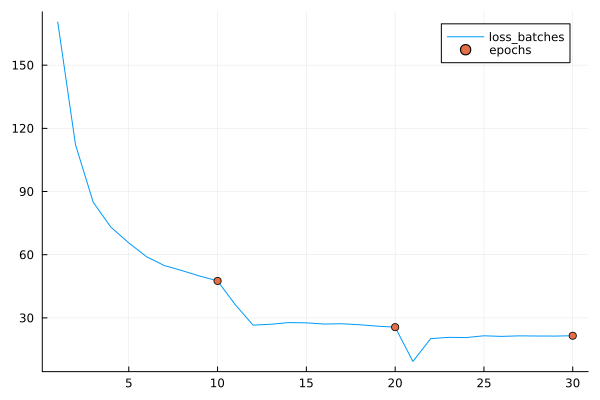

In [13]:
using Plots
using BenchmarkTools: @btime
using ProfileSVG

epochs = 3
batch_size = 64
learning_rate = 0.0075
pool_size = (4,4)

model = [
    Conv2DNode(batch_size=batch_size, filters=2, kernel_size=(3,3), input_shape=(28,28,1), activation="relu"),
    MaxPoolNode(pool_size=(4,4)),
    FlattenNode(input_shape=(6,6,2)),
    DenseNode(neurons=32, activation="relu", input_shape=(prod((6,6,2)), 1)),
    DenseNode(neurons=10, activation="softmax", input_shape=(32,1))
]

graph = graph_build(model, "cross_entropy_loss")

loss = train!(graph, train_x, train_y, epochs, batch_size, learning_rate, "adam")
plot_loss(loss, epochs)

In [ ]:
test_data = mnist.test_images()
test_labels = Int64.(mnist.test_labels())

test_x =  reshape(test_data, :, 28, 28, 1) / 255.0
test_y = test_labels

n = 5000
idx = randperm(n)

test_x = test_x[idx, :,:,:]
test_y = test_y[idx]

accuracy = evaluate(graph, test_x, test_y, batch_size, pool_size)
println("Accuracy: ", accuracy)

Accuracy: 0.9088


In [ ]:
using Plots

epochs = 10
batch_size = 64
learning_rate = 0.0025
pool_size = (4,4)

model = [
    Conv2DNode(batch_size=32, filters=2, kernel_size=(3,3), input_shape=(28,28,1), activation="relu"),
    MaxPoolNode(pool_size=(4,4)),
    FlattenNode(input_shape=(6,6,2)),
    DenseNode(neurons=32, activation="relu", input_shape=(72, 1)),
    DenseNode(neurons=10, activation="softmax", input_shape=(32,1))
]

graph = graph_build(model)

loss = train!(graph, train_x, train_y, epochs, batch_size, learning_rate, "adam")
plot_loss(loss, epochs)

----EPOCH 1----
(64, 26, 26, 2)
0/79 avg epoch loss: 147.52457
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
8/79 avg epoch loss: 143.14738
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
16/79 avg epoch loss: 130.03402
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
24/79 avg epoch loss: 108.22491
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
32/79 avg epoch loss: 92.05772
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
40/79 avg epoch loss: 81.53964
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
(64, 26, 26, 2)
48/79 avg ep

LoadError: BoundsError: attempt to access 99-element Vector{Float64} at index [100]

In [ ]:
accuracy = evaluate(graph, test_x, test_y, batch_size, pool_size)
println("Accuracy: ", accuracy)

Accuracy: 0.851
